## SAGA Paper 4, FIGURE 5:  Quenched fractions vs. r_proj

In [1]:
import numpy as np
from myplotstyle import plt,get_figsize

%matplotlib inline

import pandas as pd
from astropy.table import Table

from matplotlib import cm
import matplotlib.lines as mlines
import matplotlib
import matplotlib.backends.backend_pdf


from easyquery import Query, QueryMaker
import SAGA
from SAGA import ObjectCuts as C
from SAGA import HostCuts as H

from SAGA.utils import calc_cdf
from scipy.stats import norm

In [2]:
saga = SAGA.QuickStart()

SAGA `shared_dir` set to /Users/mg37/DropBox/SAGA/
SAGA `local_dir`  set to /Users/mg37/Projects/SAGA/


In [3]:
base   = H.paper3.filter(saga.object_catalog.load_combined_base_catalog())
nhosts = len(np.unique(base["HOSTID"]))
assert nhosts == 101


sats = C.is_sat.filter(base)
sats_maybe_all = Query(~C.has_spec, "p_sat_corrected > 0", C.sat_rcut).filter(base)

In [4]:
star_forming_selector =  Query("quenched_phony == 0")
quenched_selector     = Query("quenched_phony == 1")

rbins = np.linspace(10, 300, 7)
xd = 0.5 * (rbins[1:] + rbins[:-1])

In [5]:
rng = np.random.default_rng(1234)

def faster_bootstrap(sats, rbins):
    n_sat_f = sats["p_sat_corrected"].sum()
    p_sat = sats["p_sat_corrected"] / n_sat_f
    n_sat = int(n_sat_f)
    n_sat_f -= n_sat
    n_boot = 5000
    radial_boot = []
    for i in range(n_boot):
        n_sat_this = (n_sat + 1) if i >= n_boot * n_sat_f else n_sat
        radial_boot.append(calc_cdf(rng.choice(sats['RHOST_KPC'], size=n_sat_this, p=p_sat), rbins))
    return np.quantile(radial_boot, norm.sf([1, -1]), axis=0)


In [6]:
def calc_fq(count_q, count_sf):
    fq = count_q / (count_sf + count_q)
    fq_bias_corrected =  (count_q + 1) / (count_sf + count_q + 2)
    fq_err = np.sqrt(fq_bias_corrected * (1 - fq_bias_corrected) / (count_sf + count_q))


    return fq, fq_err

In [7]:
# ELVES
elves_file = 'data/compiled_elves_data.csv'


In [8]:
elves_df = pd.read_csv(elves_file)
nhost_elves = len(elves_df.groupby('HOST').groups.keys())

# LOAD GRAND LIST
grand_list = saga.host_catalog.load_master_list()

# MAKE LIST OF 28 ELVES HOST NAMES
elves_host_list = elves_df.Name_Host.value_counts().keys()

# ACCOUNTING FOR ELVES HOSTS THAT HAVE DIFF NAMES IN GRAND LIST
elves_name_dict = {'CENA'  :'NGC5128',
                   'M104'  :'NGC4594',
                   'M81'  :'NGC3031',
                   'NGC253'  :'NGC0253',
                   'NGC4517'  :'NGC4437',
                   'NGC628'  :'NGC0628',
                   'NGC891'  :'NGC0891'}
rev_elves_name_dict = { v:k for k,v in elves_name_dict.items()}
# REMAKE LIST OF ELVES HOSTS, NOW SWAPPING IN GRAND LIST NAMES
elves_host_list_grand_list_convention = [elves_name_dict.get(item,item)  for item in elves_host_list]

# DEFINE MINIMAL SAGA HOST CUTS (ENV + STELLAR MASS CUTS)
min_cuts = Query(
    "BRIGHTEST_K_R1 >= K_TC + 1.6",
    "M_HALO < 13",
    "K_ABS >= -24.6",
    "K_ABS <= -23.0"
)

# APPLY CUTS TO GRAND LIST
min_cuts_df = min_cuts.filter(grand_list).to_pandas()

# CROSSMATCH ELVES SELECTED GRAND LIST WITH ELVES DF USING ELVES NAMES
elves_min_cuts_list_glc = min_cuts_df[min_cuts_df['COMMON_NAME'].isin(elves_host_list_grand_list_convention)]['COMMON_NAME'].values
elves_min_cuts_list = [rev_elves_name_dict.get(item,item)  for item in elves_min_cuts_list_glc]
elves_min_cuts_df = elves_df[elves_df['HOST'].isin(elves_min_cuts_list)].copy()



In [9]:
elves = Table.from_pandas(elves_min_cuts_df)
elves_all = Table.read(elves_file)

print('All ELVES hosts',np.size(np.unique(elves_all['HOST'])))
print('MW-like ELVES hosts',np.size(np.unique(elves['HOST'])))

All ELVES hosts 28
MW-like ELVES hosts 14


## Calculate ELVES

In [10]:
#ELVES PROJECTED RADIUS
##################
elves_q    = elves['quenched'] == 1
elves_gold = elves['log_sm'] > 7.5

mask_sf = ~elves_q & elves_gold
mask_q = elves_q & elves_gold

count_sf = np.histogram(elves["RHOST_KPC"][mask_sf], rbins, weights=elves["Psat"][mask_sf])[0]
count_q  = np.histogram(elves["RHOST_KPC"][mask_q], rbins, weights=elves["Psat"][mask_q])[0]

eqfr, eqfr_err = calc_fq(count_q, count_sf)

########
elves_q    = elves_all['quenched'] == 1
elves_gold = elves_all['log_sm'] > 7.5

mask_sf = ~elves_q & elves_gold
mask_q = elves_q & elves_gold

count_sf2 = np.histogram(elves_all["RHOST_KPC"][mask_sf], rbins, weights=elves_all["Psat"][mask_sf])[0]
count_q2  = np.histogram(elves_all["RHOST_KPC"][mask_q], rbins, weights=elves_all["Psat"][mask_q])[0]


eqfr2, eqfr2_err = calc_fq(count_q2, count_sf2)

In [11]:
# GOLD SATELLITES BINNED BY PROJECTED RADIUS

t = Query(C.sample_gold, star_forming_selector).filter(base, ["RHOST_KPC", "p_sat_corrected"])
count_sf = np.histogram(t["RHOST_KPC"], rbins, weights=t["p_sat_corrected"])[0]

t = Query(C.sample_gold, quenched_selector).filter(base, ["RHOST_KPC", "p_sat_corrected"])
count_q = np.histogram(t["RHOST_KPC"], rbins, weights=t["p_sat_corrected"])[0]

qf, qf_err = calc_fq(count_q, count_sf)


In [12]:
def find_half_radius(rbins, radial_plain,radial_boot16, radial_boot84):

    mn = np.argmin(np.abs(radial_plain - 0.5))
    mn16 = np.argmin(np.abs(radial_boot16 - 0.5))
    mn84 = np.argmin(np.abs(radial_boot84 - 0.5))

    return rbins[mn],rbins[mn16],rbins[mn84]

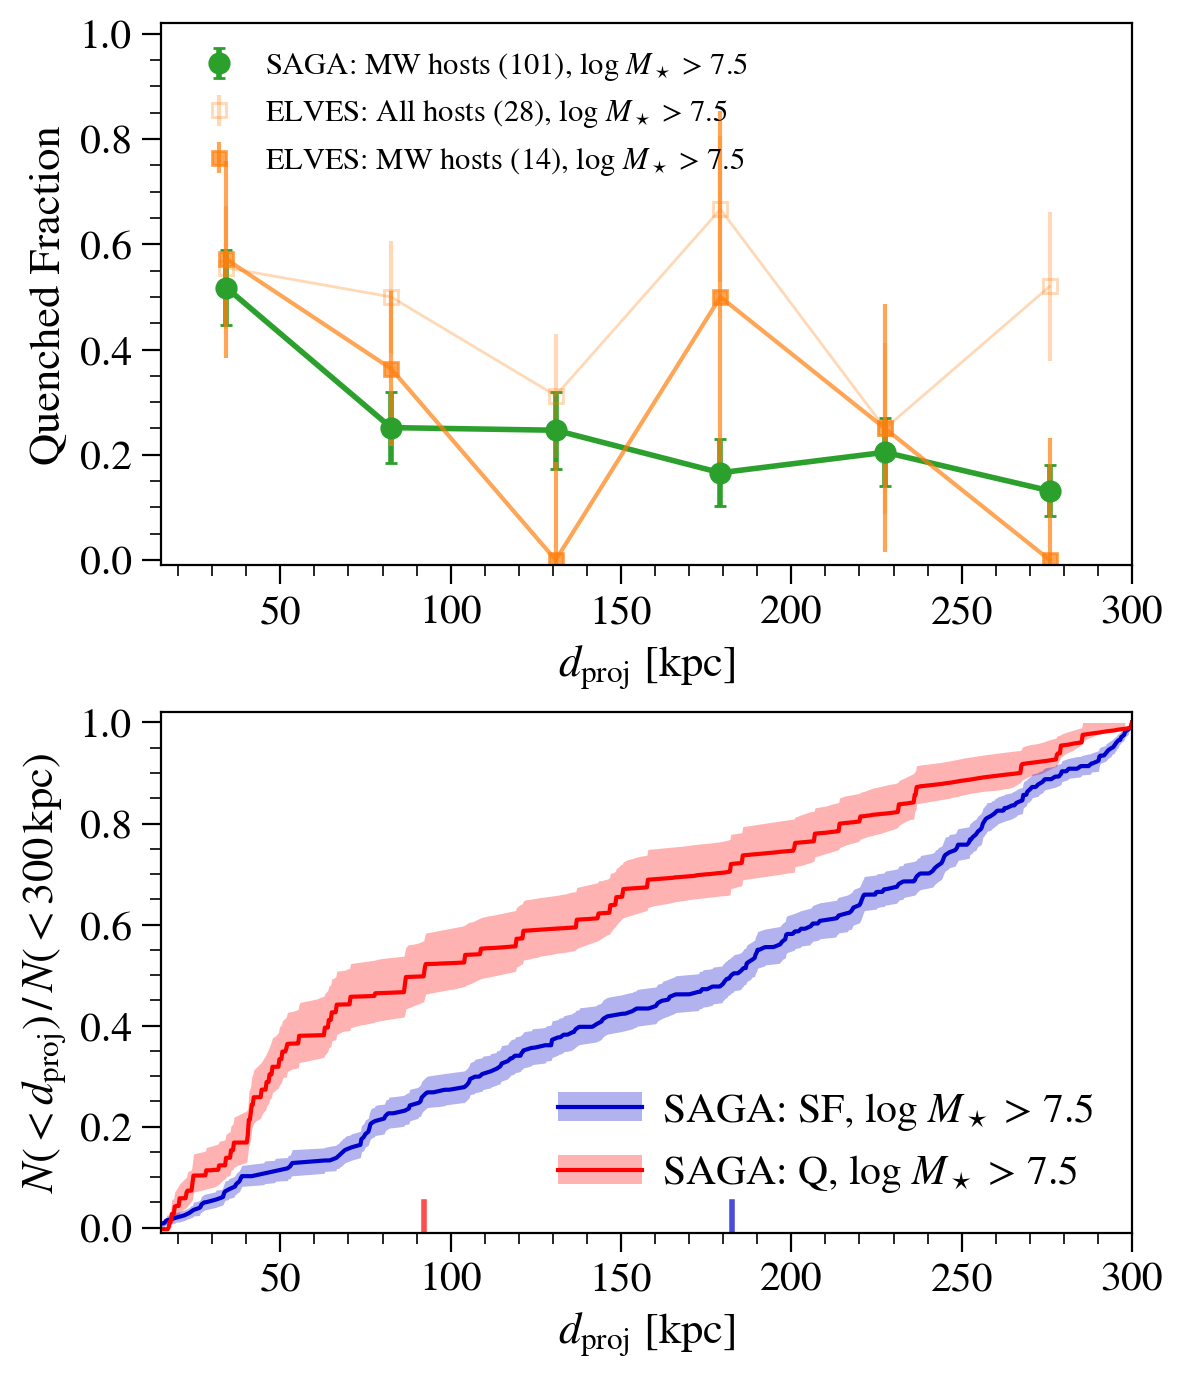

In [13]:
pdf = matplotlib.backends.backend_pdf.PdfPages('figure_quenched_radial.pdf')

fig, (ax1,ax2) = plt.subplots(nrows=2,gridspec_kw={'height_ratios': [1, 0.96]},\
                              figsize=get_figsize(wide=False, ratio=0.85))


ax1.errorbar(xd, qf, qf_err, label=r'SAGA: MW hosts (101), $\log\,M_\star$ > 7.5',ls='', marker='o', lw=2, capsize=2, ms=7, c="C2")
ax1.plot(xd, qf, 'o',lw=2, c="C2",label='__nolab__',ls='-')


ax1.errorbar(xd, eqfr2, eqfr2_err, label=r'ELVES: All hosts (28), $\log\,M_\star$ > 7.5',c='C1',alpha=0.3,fmt='s',mfc='none')
ax1.errorbar(xd, eqfr, eqfr_err, label=r'ELVES: MW hosts (14), $\log\,M_\star$ > 7.5',c='C1',\
             alpha=0.7,fmt='s')

ax1.plot(xd, eqfr2,  label='__nolabel__',c='C1',alpha=0.3,lw=1)
ax1.plot(xd, eqfr,  label='__nolabel__',c='C1',alpha=0.7,lw=1.5)


ax1.legend(loc='upper left',fontsize=11)
ax1.set_ylabel('Quenched Fraction')

######################
#GOLD
g1 = Query(C.sample_gold, star_forming_selector).filter(base, ["RHOST_KPC", "p_sat_corrected"])

rbins_cdf = np.linspace(10, 300, 1001)
radial_plain = calc_cdf(g1['RHOST_KPC'], rbins_cdf, weights = g1["p_sat_corrected"])
radial_boot16, radial_boot84 = faster_bootstrap(g1, rbins_cdf)
sf_half,sf_half16,sf_half84 = find_half_radius(rbins_cdf, radial_plain,radial_boot16, radial_boot84)

sf_g = np.sum(g1["p_sat_corrected"])
sfcol = 'mediumblue'
sf, = ax2.plot(rbins_cdf, radial_plain, c=sfcol,label='SF - gold ({})'.format(sf_g),zorder=2)
sfr =ax2.fill_between(rbins_cdf, radial_boot16, radial_boot84, color=sfcol, alpha=0.3,zorder=2, lw=0)


g2 = Query(C.sample_gold, quenched_selector).filter(base, ["RHOST_KPC", "p_sat_corrected"])

radial_plain = calc_cdf(g2['RHOST_KPC'], rbins_cdf,weights = g2["p_sat_corrected"])
qq, = ax2.plot(rbins_cdf, radial_plain, c="r",label='Q - gold')

radial_boot16, radial_boot84 = faster_bootstrap(g2, rbins_cdf)
qqr = ax2.fill_between(rbins_cdf, radial_boot16, radial_boot84, color="r", alpha=0.3, lw=0)
q_half,q_half16,q_half84 = find_half_radius(rbins_cdf, radial_plain,radial_boot16, radial_boot84)

ax2.legend([(sf,sfr),(qq,qqr)],[r'SAGA: SF, $\log\,M_\star$ > 7.5',r'SAGA: Q, $\log\,M_\star$ > 7.5'])
ax1.set_xlabel(r"$d_{\rm proj}$ [kpc]")
ax2.set_xlabel(r"$d_{\rm proj}$ [kpc]")

ax1.set_ylabel('Quenched Fraction')
ax2.set_ylabel(r"$N(<d_{\rm proj})\,/\,N(<300\,{\rm kpc})$")

ax1.set_ylim(-0.01,1.02)
ax2.set_ylim(-0.01,1.02)

ax1.set_xlim(15,300)
ax2.set_xlim(15,300)

ax2.plot([sf_half,sf_half],[-0.01,0.05],lw=2,c=sfcol,alpha=0.7)
ax2.plot([q_half,q_half],[-0.01,0.05],lw=2,c='r',alpha=0.7)

pdf.savefig()
pdf.close()

In [14]:
print('sf half = {:0.0f}  +{:0.0f}  -{:0.0f}'.format(sf_half,sf_half16-sf_half,sf_half-sf_half84))
print('q half  = {:0.0f}  +{:0.0f}  -{:0.0f}'.format(q_half,q_half16-q_half,q_half-q_half84))

print()
print('sf half = {:0.1f}  {:0.1f}  {:0.1f}'.format(sf_half,sf_half16,sf_half84))
print('q half  = {:0.1f}  {:0.1f}  {:0.1f}'.format(q_half,q_half16,q_half84))


sf half = 183  +7  -14
q half  = 92  +22  -26

sf half = 182.5  189.2  168.3
q half  = 92.1  114.1  66.3


## Generate binned table data

In [15]:
for r,a,b in zip(xd, qf, qf_err):
    print('{:0.1f}\t  {:0.2f}\t  {:0.2f}\t  {:0.2f}'.format(r, a,b,b))


34.2	  0.52	  0.07	  0.07
82.5	  0.25	  0.07	  0.07
130.8	  0.25	  0.07	  0.07
179.2	  0.17	  0.06	  0.06
227.5	  0.20	  0.07	  0.07
275.8	  0.13	  0.05	  0.05
